**its a basic nlp project to demonstrate vectorization and use of tf-idf and model evaluation**

In [1]:
import pandas as pd

messages = pd.read_csv('spam.csv',encoding='latin1') # non-utf file encode

messages = messages.iloc[:,[0,1]]
messages.columns = ["label", "message"]

messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [2]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [3]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [4]:
# Let's make a new column to detect how long the text messages are:

messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


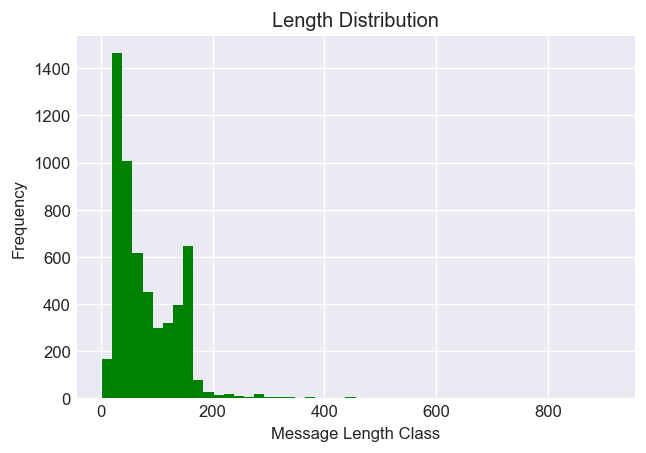

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt


plt.style.use('seaborn-darkgrid')

fig = plt.figure(dpi = 120)
ax = plt.axes()
messages['length'].plot(bins=50, kind='hist',ax=ax,color = 'green')
ax.set(xlabel = 'Message Length Class',ylabel = 'Frequency',title = 'Length Distribution');

In [9]:
messages.length.describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: length, dtype: float64

In [10]:
# Max is 910 characters, let's use masking to find this message:

messages[messages['length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

**let's see if message length is a distinguishing feature between ham and spam**

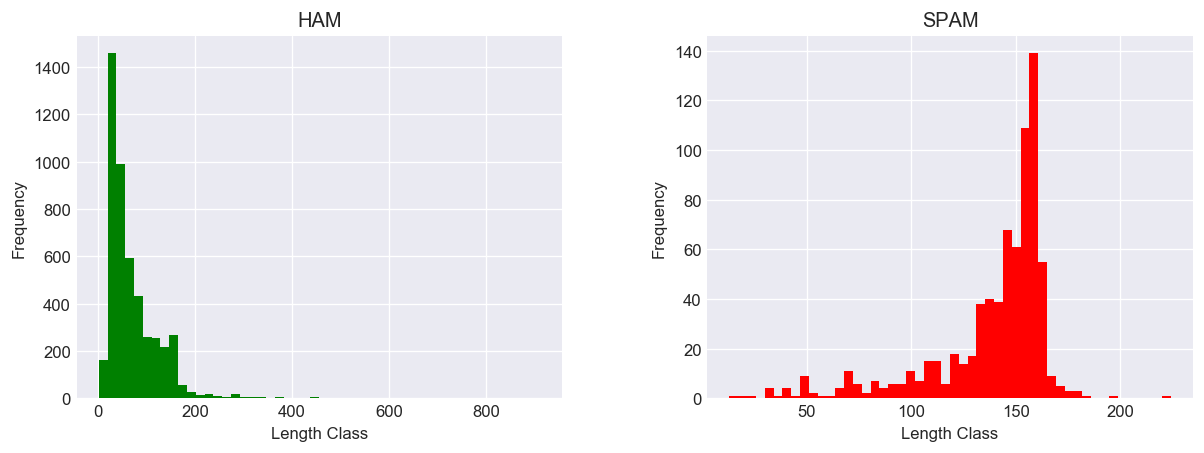

In [11]:
fig,ax = plt.subplots(1,2,figsize=(12,4),dpi = 120)

messages[messages['label']=='ham'].hist(column='length', bins=50,ax=ax[0],color = 'green')
ax[0].set(xlabel = 'Length Class',ylabel = 'Frequency',title = 'HAM')
messages[messages['label']=='spam'].hist(column='length', bins=50,ax=ax[1],color = 'red')
ax[1].set(xlabel = 'Length Class',ylabel = 'Frequency',title = 'SPAM');

looks like spam messages tend to be more lengthy

## preprocessing

Our main issue with our data is that it is all in strings. The classification algorithms that we are going to use will need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the the bag-of-words approach, where each unique word in a text will be represented by one number.

In [12]:
from nltk.corpus import stopwords
import string

def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [13]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [14]:
# let's "tokenize" these messages. Tokenization is just the term used to describe the process of converting 
# the normal text strings in to a list of words that we actually want

messages['message'].head(5).apply(text_process)

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - 'C:\\Users\\faisal/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\faisal\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\faisal\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [16]:
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

**Vectorization**
Currently, we have the messages as lists of tokens (also known as lemmas) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

For example:

                        Message 1	Message 2	...	   Message N
    Word 1 Count	        0	       1	    ...	       0
    Word 2 Count	        0	       0	    ...	       0
    ...	                1	       2	    ...	       0
    Word N Count	        0	       1	    ...	       1

Since there are so many messages, we can expect a lot of zero counts for the presence of that word in that document. Because of this, SciKit Learn will output a Sparse Matrix.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

print(len(bow_transformer.vocabulary_))

11304


In [18]:
# Let's take one text message and get its bag-of-words counts as a vector, putting to use our new bow_transformer

message4 = messages['message'][3]
print(message4)

U dun say so early hor... U c already then say...


In [19]:
# lets see its vector representation

bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 3996)	2
  (0, 4551)	1
  (0, 5179)	1
  (0, 6118)	1
  (0, 6136)	1
  (0, 7091)	1
  (0, 9445)	2
(1, 11304)


This means that there are seven unique words in message number 4 (after removing common stop words). Two of them appear twice, the rest only once. Lets check and confirm which ones appear twice.

In [20]:
print(bow_transformer.get_feature_names()[3996])
print(bow_transformer.get_feature_names()[9445])

U
say


Now we can use .transform on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages. Lets check out how the bag-of-words counts for the entire SMS corpus is a large, sparse matrix

In [21]:
messages_bow = bow_transformer.transform(messages['message'])

print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 11304)
Amount of Non-Zero occurences:  50193


In [22]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


In [23]:
# using tf-idf

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 9445)	0.5391515179363724
  (0, 7091)	0.438375519235493
  (0, 6136)	0.3183143011307023
  (0, 6118)	0.2991551295536476
  (0, 5179)	0.2969195675145299
  (0, 4551)	0.26585776633899993
  (0, 3996)	0.40924708612713756


In [24]:
# We'll go ahead and check what is the IDF (inverse document frequency) of the word "u" and of word "university"

print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

3.288863056423095
8.527076498901426


In [25]:
# To transform the entire bag-of-words corpus into TF-IDF corpus at once

messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11304)


In [26]:
# model training

from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])

print('predicted:', spam_detect_model.predict(tfidf4)[0])
print('expected:', messages.label[3])

predicted: ham
expected: ham


In [27]:
# model evaluation

all_predictions = spam_detect_model.predict(messages_tfidf)
print(all_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


In [28]:
# checking precision, f1 score

from sklearn.metrics import classification_report
print (classification_report(messages['label'], all_predictions))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4825
        spam       1.00      0.85      0.92       747

    accuracy                           0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572



In the above "evaluation",we evaluated accuracy on the same data we used for training. Such evaluation tells us nothing about the true predictive power of our model. A proper way is to split the data into a training/test set, where the model only ever sees the training data during its model fitting and parameter tuning. 

In [29]:
# train test split

from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


**Data Pipeline**

Let's run our model again and then predict off the test set. We will use SciKit Learn's pipeline capabilities to store a pipeline of workflow. This will allow us to set up all the transformations that we will do to the data for future use. 

Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification.

In [30]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()),
])

In [31]:
# Now we can directly pass message text data and the pipeline will do our pre-processing for us

pipeline.fit(msg_train,label_train)

In [32]:
predictions = pipeline.predict(msg_test)

print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98      1008
        spam       0.71      1.00      0.83       107

    accuracy                           0.96      1115
   macro avg       0.86      0.98      0.91      1115
weighted avg       0.97      0.96      0.96      1115

